In [1]:
#taken from https://colab.research.google.com/drive/1SkQbrWTQHpQFrG4J2WoBgGZC9yAzUas2?usp=sharing#scrollTo=Z1lwekV6pLYz

# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

In [2]:
# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_eager_execution()
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False)
tf.compat.v1.experimental.output_all_intermediates(True)

In [3]:
# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()

In [4]:
# let's load up MNIST
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train_all = x_train_all.astype('float')/255
x_test_all = x_test_all.astype('float')/255

x_train_all = np.pad(x_train_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]
x_test_all = np.pad(x_test_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]

vol_shape = list(x_train_all.shape[1:-1])

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
# extract all 3s
digit = 3

x_train = x_train_all[y_train_all == digit, ...]
y_train = y_train_all[y_train_all == digit]
x_test = x_test_all[y_test_all == digit, ...].astype('float')/255
y_test = y_test_all[y_test_all == digit]

In [6]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs

# let's make sure the sizes make sense
sample = next(template_gen(x_train, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

([(8, 32, 32, 1), (8, 32, 32, 1)],
 [(8, 32, 32, 1), (8, 32, 32, 2), (8, 32, 32, 2), (8, 32, 32, 2)])

In [7]:
# back to MNIST, all digits this time
x_train = x_train_all
y_train = y_train_all
y_train_onehot = tf.keras.utils.to_categorical(y_train_all, 10)
x_test = x_test_all
y_test = y_train_all
vol_shape = list(x_train.shape[1:-1])

In [8]:
# prepare a simple generator. 
def cond_template_gen(x, y, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  atlas = np.repeat(np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [y[idx, ...], atlas, img]

    outputs = [img, zero, zero, zero]
    yield inputs, outputs

sample = next(cond_template_gen(x_train, y_train_onehot, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

([(8, 10), (8, 32, 32, 1), (8, 32, 32, 1)],
 [(8, 32, 32, 1), (8, 32, 32, 2), (8, 32, 32, 2), (8, 32, 32, 2)])

In [9]:
nf_enc = [16,32,32,32]
nf_dec = [32,32,32,32,16,16,3] 
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

model = vxm.networks.ConditionalTemplateCreation(vol_shape, pheno_input_shape=[10], nb_unet_features=[enc_nf, dec_nf], conv_nb_features=16,
                                                 conv_image_shape = [4, 4, 8], conv_nb_levels=4)
# model.summary()

In [10]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
losses = [image_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss, vxm.losses.MSE().loss]
loss_weights = [1, 0.01, 0.03, 0]  # changed second-last to 0.01


model.compile('adam', loss=losses, loss_weights=loss_weights)

In [11]:
# fit
gen = cond_template_gen(x_train, y_train_onehot, batch_size=32)
hist = model.fit(gen, epochs=100, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

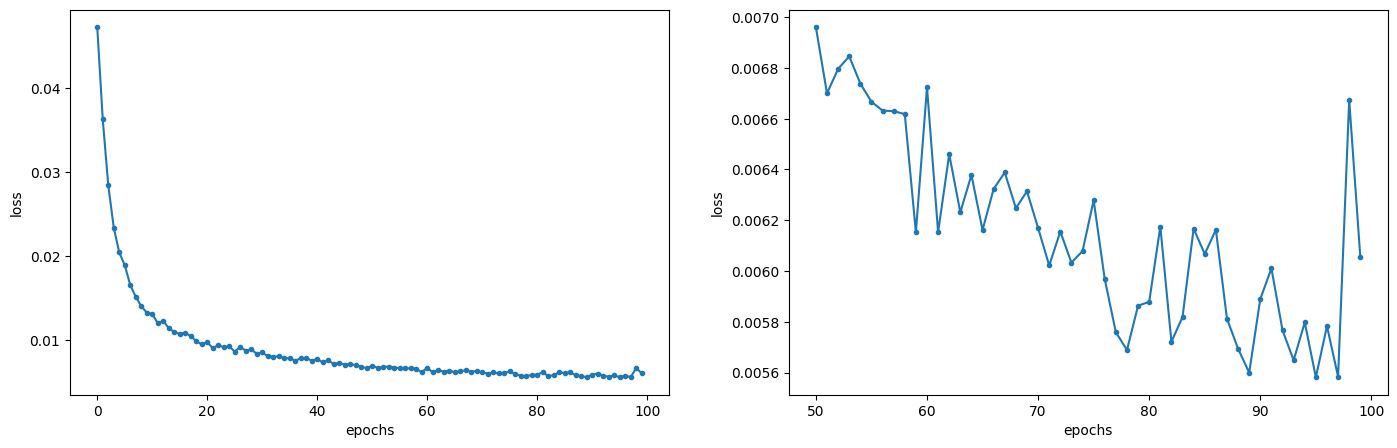

In [12]:
plot_hist(hist)

In [13]:
atlas_model = tf.keras.models.Model(model.inputs[:2], model.get_layer('atlas').output)

In [14]:
mean_atlas = np.repeat(np.mean(x_train, 0, keepdims=True), 10, 0)
input_samples = [tf.keras.utils.to_categorical(np.arange(10), 10), mean_atlas]

/mnt/disks/sdb/Slicer/lib/Python/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


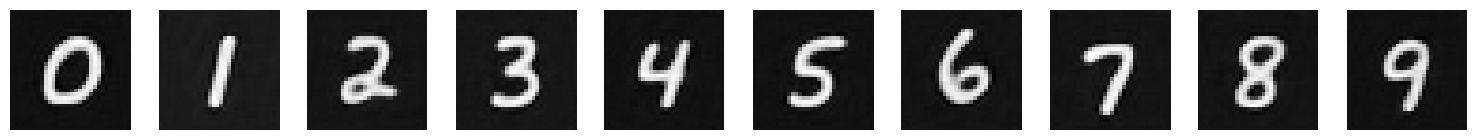

In [15]:
pred = atlas_model.predict(input_samples)
ne.plot.slices([f.squeeze() for f in pred], cmaps=['gray']);